# Out-of-the-box face-blurring methods
EECS 504 Project, F20

### Instructions: 
1. Ensure that the following files are in your current directory: 
- res10_300x300_ssd_iter_140000.caffemodel
- deploy.prototxt
- the XML file
- your image of choice

2. Enter your image's name in the next cell

In [2]:
img_name = "messi2.jpeg"

In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os

cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Haar Cascade
### Function: find_and_blur
Requires: 1 image with two different color schemes, grayscale and color. Returns: image with face blurred.

https://medium.com/swlh/anonymize-facial-data-on-video-blur-peoples-faces-using-opencv-14ce5ed1f1aa

In [4]:
def find_and_blur(bw, color): 
    
    faces = cascade.detectMultiScale(bw, 1.1, 4) #what detects the faces, will only take grayscale
    
    # get the locations of the faces
    for (x, y, w, h) in faces:
        # select the areas where the face was found
        roi_color = color[y:y+h, x:x+w]
        # blur the colored image
        blur = cv2.GaussianBlur(roi_color, (101,101), 0)        
        # Insert ROI back into image
        color[y:y+h, x:x+w] = blur            
    
    # return the blurred image
    return color

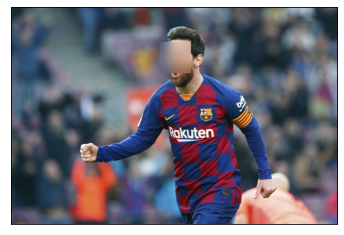

In [5]:
# Read in image
img = cv2.imread(img_name, cv2.IMREAD_COLOR)
bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect the face and blur it
blur = find_and_blur(bw, img)

# Display output
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

# DNN (RESnet)
### Function: anonymize_face_pixelate
Requires: image, blocks = # of pixels to make face. Returns: pixelated image. 

https://www.pyimagesearch.com/2020/04/06/blur-and-anonymize-faces-with-opencv-and-python/

In [6]:
def anonymize_face_pixelate(image, blocks=3):
    # divide the input image into NxN blocks
    (h, w) = image.shape[:2]
    xSteps = np.linspace(0, w, blocks + 1, dtype="int")
    ySteps = np.linspace(0, h, blocks + 1, dtype="int")
    # loop over the blocks in both the x and y direction
    for i in range(1, len(ySteps)):
        for j in range(1, len(xSteps)):
            # compute the starting and ending (x, y)-coordinates
            # for the current block
            startX = xSteps[j - 1]
            startY = ySteps[i - 1]
            endX = xSteps[j]
            endY = ySteps[i]
            # extract the ROI using NumPy array slicing, compute the
            # mean of the ROI, and then draw a rectangle with the
            # mean RGB values over the ROI in the original image
            roi = image[startY:endY, startX:endX]
            (B, G, R) = [int(x) for x in cv2.mean(roi)[:3]]
            cv2.rectangle(image, (startX, startY), (endX, endY),
    (B, G, R), -1)
    # return the pixelated blurred image
    return image

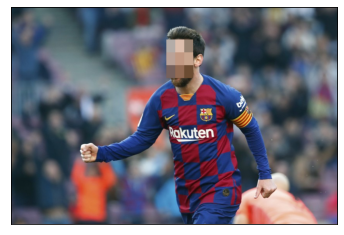

In [8]:
# load our serialized face detector model from disk
prototxtPath = os.path.sep.join([os.getcwd(), "deploy.prototxt"])
weightsPath = os.path.sep.join([os.getcwd(),"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the input image from disk, clone it, and grab the image spatial dimensions
image = cv2.imread(img_name,cv2.IMREAD_COLOR)
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the detection
    confidence = detections[0, 0, i, 2]

    # filter out weak detections by ensuring the confidence is greater than the minimum confidence
    if confidence > 0.5:
        # compute the (x, y)-coordinates of the bounding box for the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # extract the face ROI
        face = image[startY:endY, startX:endX]

        face = anonymize_face_pixelate(face, blocks=3)
    
        # store the blurred face in the output image
        image[startY:endY, startX:endX] = face

# display the original image and the output image with the blurred face(s) side by side
# output = np.hstack([orig, image])

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()